The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install mxnet-cu100


# Vector Addition

:label:`ch_vector_add_gpu`


In this section, we will optimize the vector addition defined in :numref:`ch_vector_add` on GPUs. As we have seen in :numref:`ch_gpu_arch`, the overall architecture of GPUs is not significantly different from CPUs, but GPUs often have more cores and wider SIMD units. If you are new to GPU programming, we recommend you to first read how we optimized the vector addition on CPUs in :numref:`ch_vector_add_cpu` for more contexts.

In [1]:
%matplotlib inline
import tvm
import numpy as np
import d2ltvm
import mxnet as mx
import timeit 

Since NumPy only runs on CPUs, we use MXNet as our baseline. The following code block plots the performance baseline as a function of vector length.

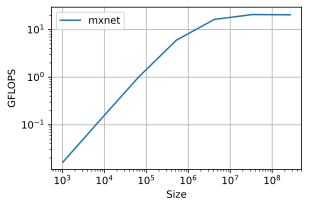

In [2]:
sizes = 2**np.arange(10, 30, 3)

mx_add = lambda n: timeit.Timer(
    setup='import mxnet as mx\n'
    'import d2ltvm\n'
    'mx_arr = lambda x: mx.nd.array(x, ctx=mx.gpu())\n'
    'a, b, c = d2ltvm.get_abc(%d, mx_arr)' % n,
    stmt='mx.nd.elemwise_add(a, b, out=c); c.wait_to_read()')

exe_times = [d2ltvm.bench_workload(mx_add(n).timeit) for n in sizes]
mx_gflops = sizes / 1e9 / np.array(exe_times)
d2ltvm.plot_gflops(sizes, [mx_gflops], ['mxnet'])

## CUDA Programming 

CUDA is a programming interface proposed by Nvidia for high-performance parallel programming on GPUs. TVM provides an abstraction level above CUDA so that we don't bother to know the details about CUDA programming. We still, however, need to understand several concepts that are specific to CUDA. 

The first one is *CUDA kernel*, or simply *kernel*. A kernel is a small program or a function. In TVM, it's often the Lambda expression to compute elements of the output tensor, e.g. `lambda i: A[i] + B[i]` in vector addition.

The second one is *CUDA thread*, or simply *thread*. A thread is an abstracted entity that represents the execution of a kernel. Note that it's a programming abstract, not the aforementioned logic or hardware thread which actually runs. So if the vector length is 1 million, we will have 1 million threads, but apparently we cannot run all of them simultaneously. 

All these threads are grouped into blocks. If the block size is 100, 1 million threads would be partitioned into 10,000 thread blocks. The maximal number of threads in a block is 512 before CUDA 10, and 1024 after. Each thread has a unique ID. In the 1-D indexing case, the `i`-th block is indexed by `blockIdx.x`. The number of threads in each block is `blockDim.x` and the `i`-th thread within a block is indexed by `threadIdx.x`. Therefore, the overall index of a thread can be calculated as

$$i = \text{blockIdx.x} \times \text{blockDim.x} + \text{threadIdx.x}$$

It can be extended to 2-D and 3-D indexing schemes for both block and thread, where we just simply add `.y` and `.z` fields accordingly. Note that `x` is the innermost dimension while `z` is the outermost, and block is outer than thread, so the overall index of a thread in 1-D block and 3-D thread case can be calculated as

$$i = \text{blockIdx.x} \times \text{blockDim.x} \times \text{blockDim.y} \times \text{blockDim.z} + \text{threadIdx.z} \times \text{blockDim.x} \times \text{blockDim.y} + \text{blockDim.y} \times \text{blockDim.x} + \text{threadIdx.x}$$

During execution, all threads in a single block will be executed in the same core, or streaming multiprocessor (SM). We could assume that they will be executed simultaneously so we can synchronize these threads in the middle of a kernel. Different blocks may run on different cores. 

In analogy to CPUs, we parallelize thread blocks on a GPU is like we parallelize over CPU threads, while a thread block runs the workload that could be vectorized. Remember that in the last part of :numref:`ch_vector_add_cpu` we split the for-loop for vector addition for parallelization and vectorization separately, we can do it similarly in GPUs programming.

In [3]:
nt = 64  # number of threads in a block

def parallel(n):
    A, B, C = d2ltvm.vector_add(n)
    s = tvm.create_schedule(C.op)
    bx, tx = s[C].split(C.op.axis[0], factor=nt)
    s[C].bind(bx, tvm.thread_axis("blockIdx.x"))
    s[C].bind(tx, tvm.thread_axis("threadIdx.x"))
    return s, (A, B, C)

s, args = parallel(256)
tvm.lower(s, args, simple_mode=True)

produce c {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 4
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 64
  c[((blockIdx.x*64) + threadIdx.x)] = (a[((blockIdx.x*64) + threadIdx.x)] + b[((blockIdx.x*64) + threadIdx.x)])
}

Compared to `vectorized` defined in :numref:`ch_vector_add_cpu`, there are two major differences. 

One is that we bind axes into block and thread indexing axes instead of call `parallel` and `vectorize`. The inner axis length is 64, specified by `nt`. Binding the `threadIdx.x` thread axis on it means that we will create 64 threads in a thread block. Similarly, binding the `blockIdx.x` thread axis on the outer axis leads to `n/nt` thread blocks. 

The other one is that the pseudo codes only have the kernel, instead of the whole program with for-loops. The indexing is obtained by the 1-D indexing scheme we shown before. 

If you have written CUDA codes before, you may want to check the generated CUDA program. Note that the target is set to be `cuda`, instead of `llvm` for CPUs, during compiling.

In [4]:
mod = tvm.build(s, args, 'cuda')
dev_mod = mod.imported_modules[0]
print(dev_mod.get_source())

extern "C" __global__ void default_function_kernel0( float* __restrict__ c,  float* __restrict__ a,  float* __restrict__ b) {
  c[((((int)blockIdx.x) * 64) + ((int)threadIdx.x))] = (a[((((int)blockIdx.x) * 64) + ((int)threadIdx.x))] + b[((((int)blockIdx.x) * 64) + ((int)threadIdx.x))]);
}




As mentioned in :numref:`ch_gpu_arch`, GPUs have their own on-board memories. To execute an operation on a GPU, we need to copy the data from the main memory to its memory. For Nvidia GPUs, the context for the $i$-th GPU can be presented by either `tvm.context('cuda', i)` or simply `tvm.gpu(i)`. The following code block copies data to the first GPU of the system. Note the `gpu(0)` shown in the first line.

In [5]:
ctx = tvm.gpu(0)
tvm.nd.array(np.zeros((3,3)), ctx)

<tvm.NDArray shape=(3, 3), gpu(0)>
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Remember that the `bench_vector_add_tvm` method already takes care of the context. Now let's benchmark the above schedule against MXNet.

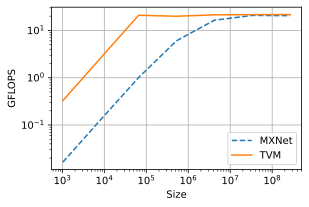

In [6]:
tvm_gflops = d2ltvm.bench_vector_add_tvm(parallel, sizes, 'cuda')
d2ltvm.plot_gflops(sizes, [mx_gflops, tvm_gflops], ['MXNet', 'TVM'])

We can see that TVM is faster for small workloads. That is because TVM uses `cython` for the foreign function interface, which is significantly faster than the `ctypes` used in MXNet. 

Note that if you are running the above code on GPUs with faster memory, such as V100, you may find TVM performs worse compared to MXNet for large vectors. You can improve it by increasing the number of threads `nt`. 

## Summary

- GPU introduces a thread-block abstraction for parallel programming. We can bind axes to threads or thread-blocks through `bind`.
- We need to allocate each streaming multiprocessor (SM) enough workloads for good performance.